In [21]:
from typing import Dict
import json
import logging

from overrides import overrides

import tqdm

from allennlp.common import Params
from allennlp.common.file_utils import cached_path
from allennlp.data.dataset_readers.dataset_reader import DatasetReader
from allennlp.data.fields import LabelField, TextField
from allennlp.data.instance import Instance
from allennlp.data.tokenizers import Tokenizer, WordTokenizer
from allennlp.data.token_indexers import TokenIndexer, SingleIdTokenIndexer
from allennlp.data import Vocabulary
from allennlp.data.dataset import Batch
import cytoolz
from torch.autograd import Variable
from datetime import datetime
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
from sklearn.feature_extraction.text import CountVectorizer
import json
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
import cytoolz
import tqdm
import scipy.sparse as sp
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import random
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [2]:
class FastText(nn.Module):
    """
    FastText model that implements https://arxiv.org/abs/1607.01759
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(FastText, self).__init__()
        # Note that the # of inputs dimension for embedding shall be vocab_size+1, why?
        # In the embedding, you need to set the padding_dx argument.
        # Please see http://pytorch.org/docs/master/nn.html
        print("FastText Model")
        self.embeds = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, data, length):
        """
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        
        all_embs = self.embeds(data)
        sum_emb = torch.sum(all_embs, 1)
        # Note that instead of doing tensorwise mean, you need to calculate the sum and divide by the sentence length
        # in the length tensor.
        avg_emb = sum_emb / length.float().view(-1,1)
        out = self.linear(avg_emb)
        out = self.sigmoid(out.view(-1))
        return out

In [6]:
#@DatasetReader.register("IMDBReader")
class IMDBDatasetReader(DatasetReader):
    """
    Reads a JSON-lines file containing papers from the Semantic Scholar database, and creates a
    dataset suitable for document classification using these papers.
    Expected format for each input line: {"paperAbstract": "text", "title": "text", "venue": "text"}
    The JSON could have other fields, too, but they are ignored.
    The output of ``read`` is a list of ``Instance`` s with the fields:
        title: ``TextField``
        abstract: ``TextField``
        label: ``LabelField``
    where the ``label`` is derived from the venue of the paper.
    Parameters
    ----------
    lazy : ``bool`` (optional, default=False)
        Passed to ``DatasetReader``.  If this is ``True``, training will start sooner, but will
        take longer per batch.  This also allows training with datasets that are too large to fit
        in memory.
    tokenizer : ``Tokenizer``, optional
        Tokenizer to use to split the title and abstrct into words or other kinds of tokens.
        Defaults to ``WordTokenizer()``.
    token_indexers : ``Dict[str, TokenIndexer]``, optional
        Indexers used to define input token representations. Defaults to ``{"tokens":
        SingleIdTokenIndexer()}``.
    """
    def __init__(self,
                 label_answer: bool = False,
                 lazy: bool = False,
                 tokenizer: Tokenizer = None,
                 token_indexers: Dict[str, TokenIndexer] = None) -> None:
        super().__init__(lazy)
        self._tokenizer = tokenizer or WordTokenizer()
        self._token_indexers = token_indexers or {"tokens": SingleIdTokenIndexer()}
        self.label_answer = label_answer

    @overrides
    def _read(self, file_path):
#         content = JSONL(file_path)
#         for line in content:
        with open(cached_path(file_path), "r") as data_file:
#             logger.info("Reading instances from lines in file at: %s", file_path)
            for line in data_file:
                line = line.strip("\n")
                if not line:
                    continue
                review = json.loads(line)
                text = review['text']
                if self.label_answer:
                    label = 1 if review['meta']['label_answer'] == "POSITIVE" else 0
                else:
                    label = 1 if (review['label'] == "POSITIVE" and review['answer'] == "accept") or (review['label']=='NEGATIVE' and review['answer'] == 'reject') else 0
                yield self.text_to_instance(text,label)

    @overrides
    def text_to_instance(self, text: str, label: int) -> Instance:  # type: ignore
        # pylint: disable=arguments-differ
        tokenized_text = self._tokenizer.tokenize(text)
        text_field = TextField(tokenized_text, self._token_indexers)
        
        fields = {'text': text_field, 'length':LabelField(text_field.sequence_length(),skip_indexing=True),'label': LabelField(label,skip_indexing=True)}
        
        return Instance(fields)

    @classmethod
    def from_params(cls, params: Params) -> 'SemanticScholarDatasetReader':
        lazy = params.pop('lazy', False)
        tokenizer = Tokenizer.from_params(params.pop('tokenizer', {}))
        token_indexers = TokenIndexer.dict_from_params(params.pop('token_indexers', {}))
        params.assert_empty(cls.__name__)
        return cls(lazy=lazy, tokenizer=tokenizer, token_indexers=token_indexers)

def build_instance(file_path,label_answer = 0):
    # tokenize, stem, 
    datareader = IMDBDatasetReader(label_answer)
    instance = datareader.read(file_path)
    return instance

def build_vocabulary(instance):
    # buil vocabulary
    vocab = Vocabulary.from_instances(instance)
    print("vocab_size:",vocab.get_vocab_size())
    return vocab

def batchify(instance,vocab,batch_size = 32,lstm_flag = False,cuda_device = 0):
    # tensorize, padding, batchify
    batch_loader = []
    for batch in cytoolz.partition_all(batch_size,tqdm.tqdm(instance, leave=False)):
        batch = Batch(batch)
        batch.index_instances(vocab)
        if lstm_flag:
            tensors = batch.as_tensor_dict(batch.get_padding_lengths(),cuda_device)
            tensors = batch.as_tensor_dict({'text': {'num_tokens': int(torch.sum(tensors['length'])/batch_size)}},cuda_device)
        else:
            tensors = batch.as_tensor_dict(batch.get_padding_lengths(),cuda_device)
        batch_loader.append(tensors)
    return batch_loader

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for batch_idx,batch in enumerate(loader):
        data_batch = Variable(batch['text']['tokens'])
        labels = batch['label']
        length_batch = Variable(batch['length'])
        outputs = model(data_batch, length_batch)
        predicted = (outputs.data > 0.5).long().view(-1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    model.train()
    return (100 * correct / total)
def single_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,data_size,batch_size,weights_matrix=None,freeze_emb=False):
    if weights_matrix is not None:
        model.embeds.weight.data.copy_(torch.from_numpy(weights_matrix))
        # check using cuda and do initialization.
        # print(model.embeds.weight.data[0])
        # print(weights_matrix[0])
        print("Use pretrained embeddding")
    else:
        print("No pretrained embedding")
    if freeze_emb:
        model.embeds.weight.requires_grad = False
        print("Freeze embedding layer")
    else:
        print("embedding weight is trainable")
    print("n_iter: ",n_iter)
    print("vocab_size",vocab_size)
    print("emb_dim: ",emb_dim)
    print("learning_rate: ",learning_rate)
    print("batch_size: ",batch_size)
    print("train data size",data_size)
    print(model.parameters())
    criterion = nn.BCELoss()  
    #criterion = nn.NLLLoss()
    #criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()), lr=learning_rate) 
    start_time = datetime.now()
    step_idx = 0
    acc_list = []
    for i in range(n_iter):
        for batch_idx,batch in enumerate(train_loader):
            # Variable defined here or outside iteration?
            data_batch = Variable(batch['text']['tokens'])
            label_batch = Variable(batch['label'])
            length_batch = Variable(batch['length'])
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch.float())
            #model.train()
            #loss.backward(retain_graph=True)
            loss.backward()
            optimizer.step()
        acc = test_model(test_loader,model)
        end_time = datetime.now() -start_time
        print('Time:[{0} seconds], batch: [{1}/{2}], Epoch: [{3}/{4}], step: [{5}/{6}], Loss: {7},Acc:{8}'.format(
                end_time.seconds,batch_idx, data_size//batch_size, i+1, n_iter, step_idx+1, data_size*n_iter//batch_size, loss, acc))
#             step_idx += 1
        acc_list.append([data_size, i+1,loss,acc])

    return acc_list,model
# add Glove pretrained Embedding
def glove():
    word2vec = {}
    print("Load Glove")
    with open('glove.6B.300d.txt', 'r') as f:
        for l in f:
            line = l.split()
            word = line[0]
            word2vec[word] = np.array(line[1:]).astype(np.float)
    #word2vec = pickle.load(open("/liveperson/data/alloy/prodigy/data/6B.300_vec.pkl", 'rb'))
    matrix_len = vocab.get_vocab_size()
    weights_matrix = np.zeros((matrix_len, 300))
    words_found = 0
    for i, word in vocab.get_index_to_token_vocabulary().items():
        try: 
            weights_matrix[i] = word2vec[word]
            words_found += 1
        except KeyError:
            weights_matrix[i] = np.random.normal(scale=0.6, size=(300, ))
    print(words_found,"of ",matrix_len, "have pretrained vectors")
    return weights_matrix

In [5]:
train_data = build_instance("/data/prodigy/data/IMDB_default/unique_baseline.jsonl",1)
vocab = build_vocabulary(train_data)
more_test_data = build_instance("/data/prodigy/data/IMDB_default/IMDB_more_test.jsonl")
weights_matrix = glove()


0it [00:00, ?it/s]
21it [00:00, 205.96it/s]
41it [00:00, 202.92it/s]
71it [00:00, 234.37it/s]
89it [00:00, 218.04it/s]
114it [00:00, 223.77it/s]
133it [00:00, 185.48it/s]
153it [00:00, 187.16it/s]
174it [00:00, 189.41it/s]
197it [00:01, 192.93it/s]
220it [00:01, 196.06it/s]
243it [00:01, 198.49it/s]
265it [00:01, 195.85it/s]
288it [00:01, 198.06it/s]
311it [00:01, 199.79it/s]
333it [00:01, 198.43it/s]
358it [00:01, 200.98it/s]
385it [00:01, 204.65it/s]
410it [00:01, 206.44it/s]
434it [00:02, 207.74it/s]
458it [00:02, 200.37it/s]
482it [00:02, 202.00it/s]
507it [00:02, 203.82it/s]
530it [00:02, 203.76it/s]
555it [00:02, 205.39it/s]
578it [00:02, 205.53it/s]
601it [00:02, 206.33it/s]
625it [00:03, 207.20it/s]
653it [00:03, 209.52it/s]
678it [00:03, 208.67it/s]
701it [00:03, 206.73it/s]
722it [00:03, 206.16it/s]
752it [00:03, 208.61it/s]
775it [00:03, 208.95it/s]
798it [00:03, 202.18it/s]
819it [00:04, 202.25it/s]
843it [00:04, 202.77it/s]
864it [00:04, 201.34it/s]
889it [00:04, 201.77it

vocab_size: 34090



45it [00:00, 219.58it/s]
63it [00:00, 206.56it/s]
88it [00:00, 216.42it/s]
116it [00:00, 226.66it/s]
139it [00:00, 226.66it/s]
160it [00:00, 218.66it/s]
188it [00:00, 223.02it/s]
216it [00:00, 228.50it/s]
242it [00:01, 231.08it/s]
272it [00:01, 236.62it/s]
298it [00:01, 234.54it/s]
324it [00:01, 236.09it/s]
349it [00:01, 235.42it/s]
376it [00:01, 237.55it/s]
401it [00:01, 219.45it/s]
422it [00:01, 218.36it/s]
447it [00:02, 219.62it/s]
469it [00:02, 215.21it/s]
492it [00:02, 215.23it/s]
520it [00:02, 216.64it/s]
547it [00:02, 218.15it/s]
570it [00:02, 218.28it/s]
594it [00:02, 218.74it/s]
617it [00:02, 218.58it/s]
640it [00:02, 218.99it/s]
663it [00:03, 218.32it/s]
685it [00:03, 218.29it/s]
711it [00:03, 219.42it/s]
734it [00:03, 219.41it/s]
757it [00:03, 219.41it/s]
780it [00:03, 219.28it/s]
804it [00:03, 219.76it/s]
827it [00:03, 219.70it/s]
858it [00:03, 221.98it/s]
883it [00:03, 221.61it/s]
907it [00:04, 221.52it/s]
931it [00:04, 221.17it/s]
956it [00:04, 221.79it/s]
980it [00:04, 

Load Glove
19969 of  34090 have pretrained vectors


In [8]:
# FastText Probability Calibration
batch_size = 32
emb_dim =300
learning_rate = 0.001
n_iter = 20
cuda_device = -1

train_loader = batchify(train_data,vocab,batch_size,True,cuda_device)
test_loader = batchify(more_test_data,vocab,batch_size,True,cuda_device)

vocab_size = vocab.get_vocab_size()
train_size = len(train_data)

model = FastText(vocab_size, emb_dim)

acc,ft_model = single_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size)


 90%|████████▉ | 2240/2500 [00:00<00:00, 3056.25it/s]
                                                     
 98%|█████████▊| 4896/5000 [00:04<00:00, 1130.04it/s]
                                                     

FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 34090
emb_dim:  300
learning_rate:  0.001
batch_size:  32
train data size 2500
<generator object Module.parameters at 0x7fe4466acf10>
Time:[5 seconds], batch: [78/78], Epoch: [1/20], step: [1/1562], Loss: 0.6605809330940247,Acc:65
Time:[10 seconds], batch: [78/78], Epoch: [2/20], step: [1/1562], Loss: 0.6385488510131836,Acc:69
Time:[15 seconds], batch: [78/78], Epoch: [3/20], step: [1/1562], Loss: 0.6100111603736877,Acc:72
Time:[20 seconds], batch: [78/78], Epoch: [4/20], step: [1/1562], Loss: 0.5781949162483215,Acc:74
Time:[25 seconds], batch: [78/78], Epoch: [5/20], step: [1/1562], Loss: 0.547313392162323,Acc:76
Time:[30 seconds], batch: [78/78], Epoch: [6/20], step: [1/1562], Loss: 0.518834114074707,Acc:78
Time:[35 seconds], batch: [78/78], Epoch: [7/20], step: [1/1562], Loss: 0.4921181797981262,Acc:79
Time:[40 seconds], batch: [78/78], Epoch: [8/20], step: [1/1562], Loss: 0.4663044512271881,

In [9]:
prob_list = []
ft_model.eval()
for batch_idx,batch in enumerate(test_loader):
    data_batch = Variable(batch['text']['tokens'])
    labels = batch['label']
    length_batch = Variable(batch['length'])
    prob_list+= ft_model(data_batch, length_batch).tolist()
ft_model.train()

FastText(
  (embeds): Embedding(34090, 300, padding_idx=0)
  (linear): Linear(in_features=300, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [19]:
test_label=[]
for d in test_loader:
    test_label += d['label'].tolist()

In [36]:
def plot_calibration_curve(est,name,fig_index,X_train,y_train,X_test,y_test):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    #isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    #sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')
    #lr = linear_model.SGDClassifier(loss="log",n_jobs=-1)
    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est[0], name[0]),
                     (est[1],name[1]),
                     (est[2],name[2])]:
        clf.fit(X_train.toarray(), y_train)
        y_pred = clf.predict(X_test.toarray())
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test.toarray())[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=1)
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)
    clf_score = brier_score_loss(test_label, prob_list, pos_label=1)
    fraction_of_positives, mean_predicted_value = \
            calibration_curve(test_label,prob_list, n_bins=10)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s (%1.3f)" % ("FastText", clf_score))
    ax2.hist(prob_list, range=(0, 1), bins=10, label="FastText",
             histtype="step", lw=2)
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

In [37]:
def data_process(file_path,label_answer = 0):
    data = []
    labels = []
    with open(file_path, "r") as data_file:
        for line in data_file:
            line = line.strip("\n")
            if not line:
                continue
            review = json.loads(line)
            
            data.append(review['text'])
            if label_answer:
                labels.append(1 if review['meta']['label_answer'] == "POSITIVE" else 0)
            else:
                labels.append(1 if (review['label'] == "POSITIVE" and review['answer'] == "accept") or (review['label']=='NEGATIVE' and review['answer'] == 'reject') else 0)
    return data,labels
def shuffle_data(data,labels):
    trainset = list(zip(data,labels))
    random.shuffle(trainset)
    return zip(*trainset)

Logistic:
	Brier: 0.127
	Precision: 0.829
	Recall: 0.840
	F1: 0.834

Logistic SGD:
	Brier: 0.141
	Precision: 0.824
	Recall: 0.836
	F1: 0.830

SVM:
	Brier: 0.208
	Precision: 0.779
	Recall: 0.886
	F1: 0.829

GaussianNB:
	Brier: 0.304
	Precision: 0.733
	Recall: 0.624
	F1: 0.674



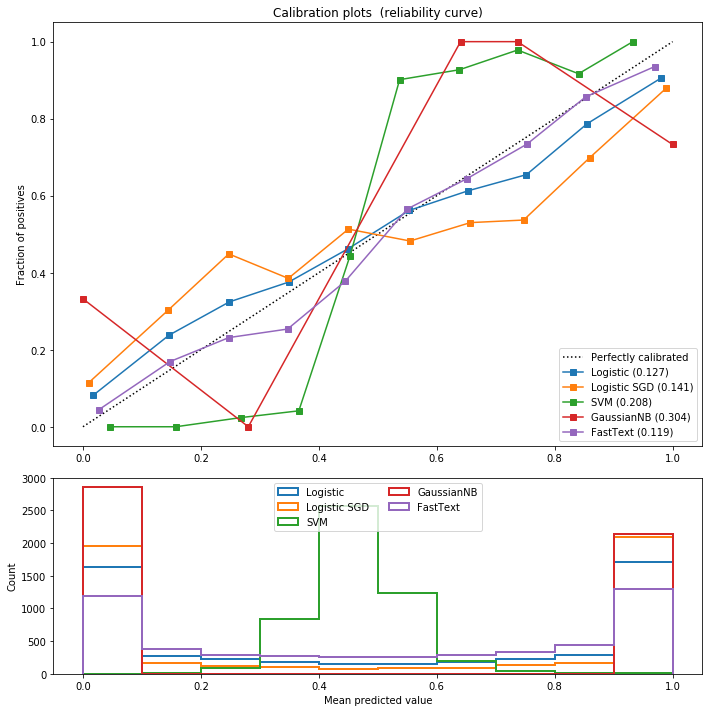

In [39]:
baseline_uni_path = "/data/prodigy/data/IMDB_default/unique_baseline.jsonl"
eval_path = "/data/prodigy/data/IMDB_default/IMDB_more_test.jsonl"
baseline_uni_data,baseline_uni_labels = data_process(baseline_uni_path,1)
eval_data,eval_labels = data_process(eval_path)
vectorizer = CountVectorizer(min_df=5,
                             max_df = 0.8)
baseline_uni_vectors = vectorizer.fit_transform(baseline_uni_data)
eval_vectors = vectorizer.transform(eval_data)
est = linear_model.SGDClassifier(loss="log",n_jobs=-1,max_iter=100)
est1 = linear_model.SGDClassifier(loss="hinge",n_jobs=-1,max_iter=100)
est2 = GaussianNB()
plot_calibration_curve([est,est1,est2],["Logistic SGD", "SVM","GaussianNB"],1,baseline_uni_vectors,baseline_uni_labels,eval_vectors,eval_labels)



In [27]:
est2.fit(baseline_uni_vectors.toarray(),baseline_uni_labels)

GaussianNB(priors=None)